Computing for forward_process_beta.png


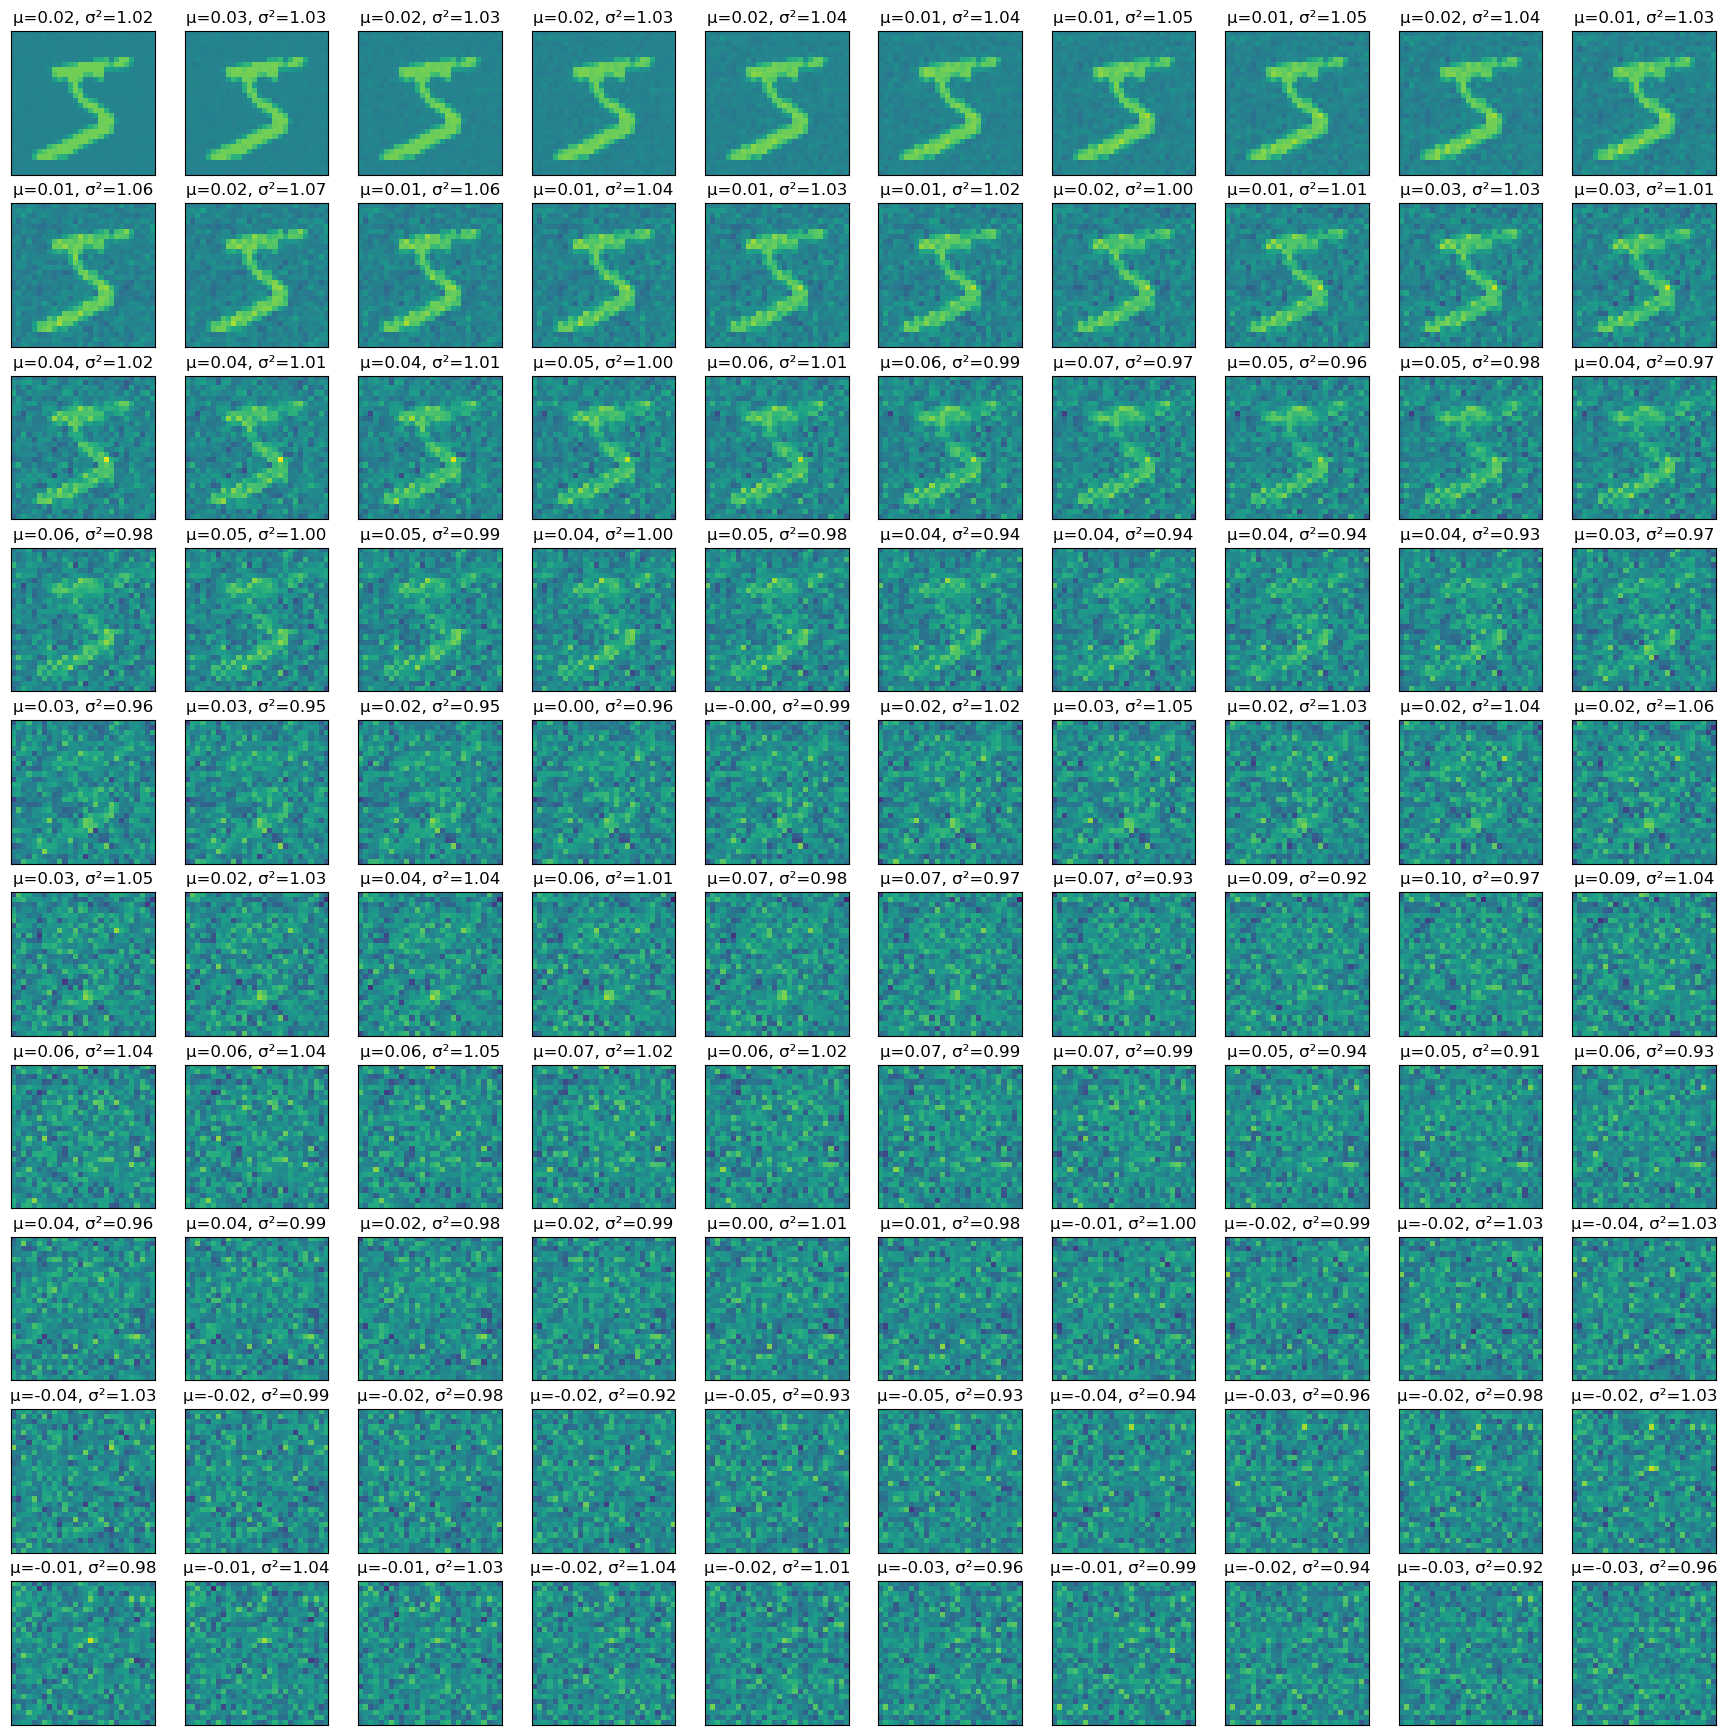

Computing for forward_process_alpha.png


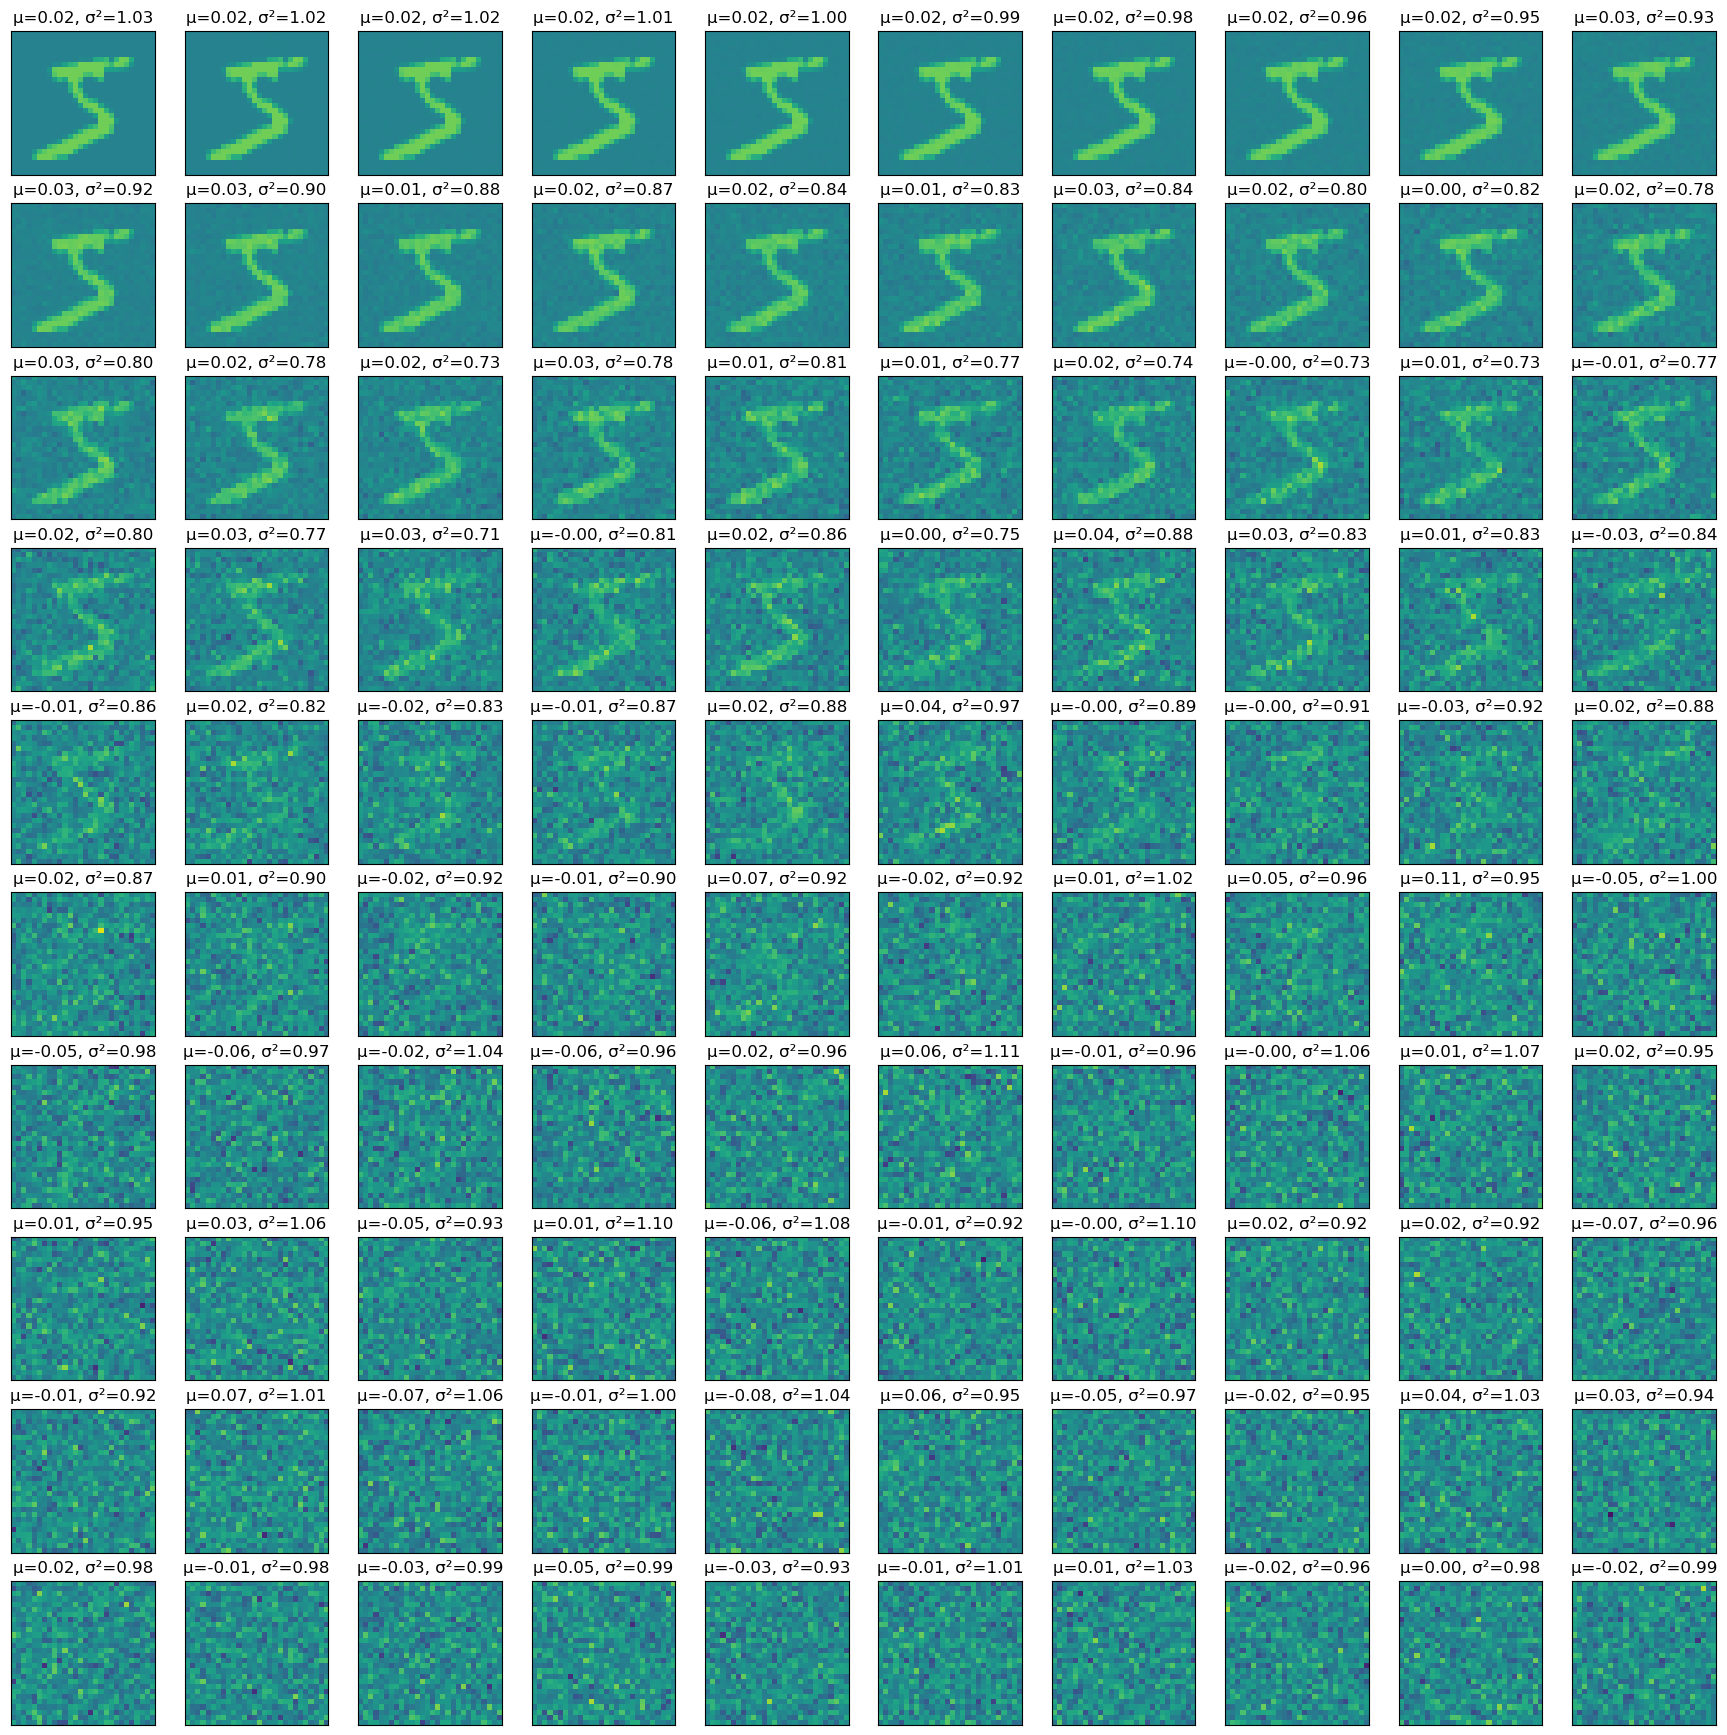

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# NOTE: The resulting images from x_beta will show an incremental accumulation of noise, where each image slightly differs from the previous one as noise accumulates progressively. In contrast, x_alpha will directly compute the image state from the initial state x0 at each step, potentially resulting in less visually smooth transitions in noise accumulation but more accurate adherence to the theoretical noise schedule when viewed at specific steps.

transform = torchvision.transforms.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = torchvision.datasets.MNIST('./../data', train=True, transform=transform, download=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)

batch, labels = next(iter(dataloader))
x0=batch[0].numpy()

T = 1000
beta_schedule = np.linspace(start=1e-4, stop=0.02, num=T)
alpha_schedule = 1 - beta_schedule
alpha_cumprod = np.cumprod(alpha_schedule) 

x_beta, x_alpha = [x0], [x0]
xt_beta, xt_alpha = x0, x0

for i in range(T):
    noise = np.random.normal(size=xt_beta.shape)

    beta = beta_schedule[i]
    xt_beta = np.sqrt(1-beta) * xt_beta + np.sqrt(beta) * noise
    x_beta.append(xt_beta)

    alpha = alpha_cumprod[i]
    xt_alpha = np.sqrt(alpha) * x0 + (1-alpha) * noise # in terms of x0
    x_alpha.append(xt_alpha)

def calculate_statistics(x_series, x0):
    means = []
    variances = []
    for img in x_series:
        mean = np.mean(img)
        variance = np.var(img)
        means.append(mean)
        variances.append(variance)
    x_series_np = np.array(x_series)
    return means, variances, x_series_np.min(), x_series_np.max()

beta_means, beta_variances, beta_min, beta_max = calculate_statistics(x_beta, x0)
alpha_means, alpha_variances, alpha_min, alpha_max = calculate_statistics(x_alpha, x0)

def plot_sequence(x, means, variances, min_value, max_value, title):
    print(f"Computing for {title}")
    fig = plt.figure(figsize=(22,22))
    columns = 10
    rows = 10
    for i in range(1, columns*rows +1):
        idx = i*T//(columns*rows)
        img = x[idx]
        fig.add_subplot(rows, columns, i, title=f"\u03BC={means[idx]:.2f}, \u03C3\u00B2={variances[idx]:.2f}")
        plt.imshow(np.array(img).transpose(1,2,0), vmin=min_value, vmax=max_value)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    # os.makedirs(os.path.join("eval", "variance_schedule"), exist_ok=True)
    # plt.savefig(os.path.join("eval", "variance_schedule", title))

overall_min = min(beta_min, alpha_min)
overall_max = max(beta_max, alpha_max)
plot_sequence(x_beta, beta_means, beta_variances, overall_min, overall_max, title="forward_process_beta.png")
plot_sequence(x_alpha, alpha_means, alpha_variances, overall_min, overall_max, title="forward_process_alpha.png")